# Homework 5 CSCI 4364/6364 Machine Learning

##**Language Models with Attention and Transformer**

**Due Date: 12/3/2024, 23:59 ET**

---

**Purpose:**
 This homework assignment will give you experience working with the Transformer architecture on a text summarization model. You will learn about generating vocabularies using subword tokenization. In real-world applications, there is a good chance that you will have to repurpose an ML architecture into a different task. Similarly, in this assignment you will convert the Portuguese-English Transformer example into a summarizer. While this is a relatively small language model, interacting with the Transformer will give you an intuition for some of the large language models (LLMs), like GPT4, Gemini, Llama and others. You will review attention weights, and evaluate the quality of your summarizer using the ROUGE score, which is a common but imperfect method of evaluating the quality of summaries.

Before you dive into this homework assignment, you should review the following papers and tutorials:
* **Attention Is all you need** (https://arxiv.org/abs/1706.03762) This is the original paper that will provide a description the design of the Transformer architecture.
* **Neural machine translation with a Transformer and Keras** (https://www.tensorflow.org/text/tutorials/transformer) This is the Tensorflow/Keras language translation model that you will convert from a translator into a summarizer.
* **Subword Tokenizer** (https://www.tensorflow.org/text/guide/subwords_tokenizer) This tutorial will provide you the background to implement your own sub-words tokenizer for the summarization task.
* **Introduction to Text Summarization with ROUGE Scores** (https://towardsdatascience.com/introduction-to-text-summarization-with-rouge-scores-84140c64b471) This post will familiarize you with the abstractive summarization task and present the ROUGE score metric, based on precision and recall of words compared to the training set.

---
**Important!**


* The models you are working with in this homework are quite advanced and require some time and TPU resources to execute. You may consider upgrading to [Colab Pro](https://colab.research.google.com/signup) or the pay-as-you-go subscription if you are running out of memory or if your session disconnects after a while. As you proceed through the assignment, take note of the overall **accuracy**, **runtime**, and the **size** (number of parameters) of your models. Finally, give yourself some time to execute the code in the homework.
* You should run this Colab with a Tensor Processor Unit (**TPU**) runtime with **High RAM** configuration.

---
**A note on using language models**

We want to address using AI tools like ChatGPT for solving programming assignments. While it’s perfectly fine to leverage such tools as a resource, it’s important to ensure that you truly understand the solutions they provide.

As you progress, please make it a priority to:
- Review and study the solutions: Take the time to understand the logic, syntax, and methodology behind the code generated by AI.
- Practice writing similar code on your own: By the end of the semester, you should be confident in solving similar problems independently, as this is crucial for your learning and future assessments.

Remember, the goal is not just to complete the assignments but to develop the skills and confidence needed to code effectively on your own.
If you have any questions or need further clarification about the solutions, don’t hesitate to reach out.



---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks. **Remember to save with outputs!**

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Vidhi Khandelwal

**GW ID:** G30891152

In [ ]:
#@title Setup Installation
!pip install datasets
!pip install rouge-score
!pip install -q -U "tensorflow-text==2.8.*"
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q -U tensorflow-text tensorflow tensorflow==2.15.0
print("NOTE: You should restart the runtime session after this completes.")

# Ignore the error:
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googleapis-common-protos 1.66.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.7 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
NOTE: You should restart the runtime session after this completes.


In [ ]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################

import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from typing import Dict, Optional, Sequence
import tensorflow as tf
from gc import callbacks
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from google.colab import drive # For saving vocabulary and model checkpoints.
from tensorflow.python.ops.numpy_ops import np_config
from IPython.display import display, HTML
from rouge_score import rouge_scorer
from datasets import load_dataset

The section below sets up folders for the vocabulary and transformer weight checkpoints on Google Drive (gDrive). This ensures that your models are saved if the colab session crashes, and you can recover an existing model from the latest checkpoint. See the [tutorial on colab IO](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA) for more details on I/O with colabs.

In [ ]:
#@title Set up the vocabulary and checkpoint paths on gDrive

drive.mount('/content/gdrive', force_remount=True)
checkpoint_filepath = F'/content/gdrive/My Drive/ml_course/hw5/models/summarizer/checkpoints'
vocabulary_filepath =  F'/content/gdrive/My Drive/ml_course/hw5/models/summarizer/vocabulary'
vocabulary_file = os.path.join(vocabulary_filepath, 'vocabulary')

# For saving the vocabulary
if not os.path.exists(vocabulary_filepath) :
  print('Creating vocabulary file path %s' %vocabulary_filepath)
  os.makedirs(vocabulary_filepath)

# For saving the model weights
if not os.path.exists(checkpoint_filepath) :
  print('Creating checkpoint directory %s' %checkpoint_filepath)
  os.makedirs(checkpoint_filepath)

Mounted at /content/gdrive


#1. Access the SummScreen dataset from TFDS

The [SummScreen dataset](https://www.tensorflow.org/datasets/catalog/summscreen#summscreentms) is  a collection of scripts and summaries from various TV shows. The goal is to analyze a portion of the script  to generate an abstractive summary. While a larger model might be able to ingest a large portion of the text, we will apply a very conservative limit on the input length. Since  will use the raw plain text input, we’ll need to create a vocabulary and tokenize the data before training a sequence-to-sequence model.

As in previous assignments, you'll be working on **TensorFlow datasets**, so you may want to review the [API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Specifically, you should review `map()`, `shuffle()`, `batch()`, and `load()`.

In [ ]:
# @title Load and configure the SummScreen dataset.

dataset = load_dataset("YuanPJ/summ_screen", 'all')


def to_dataset(df: pd.DataFrame):
  df['transcript'] = [trans[0] for trans in df['Transcript']]
  df['recap'] = [recap[0] for recap in df['Recap']]
  return tf.data.Dataset.from_tensor_slices((df['transcript'].values, df['recap'].values))

train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])


ds_train = to_dataset(train_df)
ds_val = to_dataset(validation_df)
ds_test = to_dataset(test_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


summ_screen.py:   0%|          | 0.00/5.48k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/36.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22588 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2130 [00:00<?, ? examples/s]

# 2. Create a vocabulary from the training script input data

In this section, use the training scripts to create a vocabulary using `bert_vocab.bert_vocal_from_dataset()`.  You should create TFDS mapping functions that convert the transcripts to lowercase and add `[START]` and `[END]` tokens to transcripts. Unlike the translation task, you will only have to worry about a single language vocabulary and tokenization, since the word-piece encoder works for both input (transcript) and output (recap).

##Q1 Sub-word vocabulary
Describe the advantages a sub-word vocabulary provides over a vocabulary of the same length made up of the most frequently occuring whole words.
> Answer:
Advantages of Sub-word Vocabulary Over Whole Word Vocabulary

1. Handles Rare and Unseen Words: Sub-word tokens can compose rare or unknown words, reducing the out-of-vocabulary (OOV) issue.
2. Reduces Vocabulry Size: Covers more linguistic variety with fewer tokens compared to a whole word vocabulary of the same length.
3. Language Independence: Works well with languages that have complex morphology, like Finnish or Turkish, without requiring an excessively large vocabulary.
4. Robust to Noisy Inputs: Can still process words with typos or misspellings effectively.
5. Memory and Computational Efficiency: Requires fewer parameters for storage and processing compared to a large whole word vocabulary.
6. Mitigates Out-of-Vocabulary Issues: Especially useful in dynamic and diverse applications, such as chatbots or real-time translation.
7. Enables Fine-Grained Embeddings:
Models can learn more nuanced representations by assigning embeddings to meaningful subword units.


In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
VOCABULARY_LENGTH = 8000

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = VOCABULARY_LENGTH,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")


In [ ]:
def to_lowercase(transcript, recap = ""):
  return tf.strings.lower(transcript), tf.strings.lower(recap)


def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)


def get_transcript(transcript, recap):
  return transcript

Create a vocabulary called `en_vocab` by invoking `bert_vocab_from_dataset()` that takes in a dataset the lowercased transcripts and the `**bert_vocab_args` created above. This should complete in less than 10 minutes.

In [ ]:
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    ds_train.batch(1000).map(to_lowercase).map(get_transcript).prefetch(2),
    **bert_vocab_args
)

CPU times: user 25.2 s, sys: 132 ms, total: 25.4 s
Wall time: 23.7 s


In [ ]:
# Inspect the tokens of your vocabulary at different locations:
print(en_vocab[:30])
print(en_vocab[100:110])
print(en_vocab[1000:1010])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':']
['do', 'here', 'oh', 'not', 'was', 'hey', 'don', 'previously', 'right', 'at']
['hit', 'marty', 'normal', 'park', 'prison', 'rather', 'teleplay', 'upset', '##ish', '##ley']
['##q', '##{', '##|', '##}', '##~', '##æ', '##‐', '##•', '##♪', '##�']


In [ ]:
ds_train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
#@title Save the vocabulary path to gDrive
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

write_vocab_file(vocabulary_file, en_vocab)
!cat "$vocabulary_file"
print('Saved the vocabulary to %s.' %vocabulary_file)

[PAD]
[UNK]
[START]
[END]
!
"
#
$
%
&
'
(
)
*
+
,
-
.
/
0
1
2
3
4
5
6
7
8
9
:
;
?
@
[
\
]
_
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
{
|
}
~
æ
‐
•
♪
�
you
the
to
and
it
on
that
of
is
in
me
this
what
##s
my
we
for
are
so
have
your
re
be
know
can
with
just
all
do
here
oh
not
was
hey
don
previously
right
at
there
up
no
she
get
but
he
out
want
her
about
##ing
if
how
going
okay
one
as
like
now
did
##ed
go
will
from
ve
back
good
come
well
got
see
ll
by
think
time
him
his
sighs
they
scene
tell
when
look
need
brooke
##d
gonna
really
let
or
been
where
who
door
love
please
would
##y
could
some
something
doing
why
an
hope
jack
night
thank
our
yeah
make
say
were
little
over
sorry
has
ridge
nick
way
didn
us
god
##e
down
mean
take
##er
day
hi
had
then
am
home
##ly
##t
baby
call
man
off
music
much
carly
##a
help
uh
any
because
into
michael
morning
should
more
never
##n
again
everything
give
still
sure
them
keep
last
believe
find
house
phone
room
steffy
wait
thing
anything
katie
life
too
ve

In [ ]:
#@title Load the vocabulary path from gDrive
en_tokenizer = text.BertTokenizer(vocabulary_file, **bert_tokenizer_params)

#3. Determine the max input transcript token length

The translation task has two vocabularies, and the maximum token lengths can be the same (the input and output languages have similar lengths). However, in summarization, the input transcript is significantly longer than the output recap, but both can use the same vocabulary. These are two adaptations you will have to add to make the translation architecture into a summarization architecture.

While you can use a reasonable recap (output) length of 64 tokens, you have to figure out a good length for the transcript (input) tokens. Create a histogram of token lengths from a sample of the transcripts to get a feeling for how many tokens cover most transcripts. The max length should be about 1,000 tokens. However, judging by the histogram, you can choose a smaller encoding length to cover most cases instead of all cases.


In [ ]:


for transcript_example, recap_example in ds_train.batch(256).map(to_lowercase):
  transcript_tokens = en_tokenizer.tokenize(transcript_example)
  lengths = transcript_tokens.row_lengths()
  break



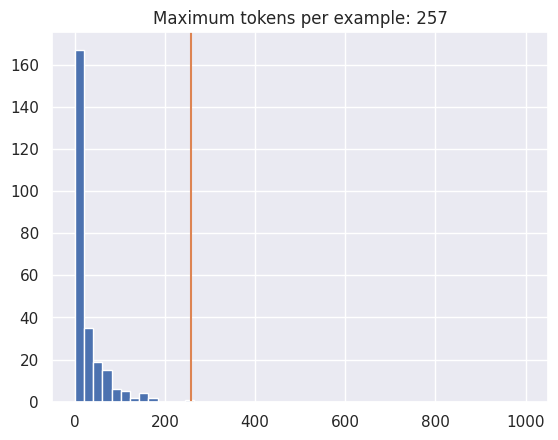

In [ ]:


plt.hist(lengths, np.linspace(0, 1000, 50))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim(), )
plt.title(f'Maximum tokens per example: {max_length}');

Set the `MAX_TOKENS_TRANSCRIPT` based on your histogram analysis. You should replace `MAX_TOKENS` with `MAX_TOKENS_TRANSCRIPT` and `MAX_TOKENS_RECAP`.

**Note**: For this assignment, we'll start with a very small max length. You should first get results (even if they're not great) with a much smaller input length (`MAX_TOKENS_TRANSCRIPT`) than the transcripts to ensure that you have enough resources to execute the assignment completely. Once you have completed the full pass to the results, you can come back and change the architecture and the input data for extra credit.

In [ ]:
MAX_TOKENS_TRANSCRIPT = 256
MAX_TOKENS_RECAP = 64

Next, adapt the transation `prepare_batch()` from the transformer tutorial colab, changing the input arguments from `pt`, `en` to `transcript`, `recap`, and output args from `(pt, en_inputs), en_labels` to `(transcript_tokens, recap_inputs), recap_labels`.

In [ ]:


def prepare_batch(transcript, recap):

    transcript_tokens = en_tokenizer.tokenize(transcript)

    transcript_tokens = transcript_tokens.merge_dims(-2,-1)

    transcript_tokens = transcript_tokens[:, :MAX_TOKENS_TRANSCRIPT]    # Trim to MAX_TOKENS.
    transcript_tokens = add_start_end(transcript_tokens)

    transcript_tokens = transcript_tokens.to_tensor()  # Convert to 0-padded dense Tensor

    recap_tokens = en_tokenizer.tokenize(recap)
    recap_tokens = recap_tokens.merge_dims(-2,-1)

    recap_tokens = recap_tokens[:, :(MAX_TOKENS_RECAP+1)]
    recap_tokens = add_start_end(recap_tokens)
    recap_inputs = recap_tokens[:, :-1].to_tensor()  # Drop the [END] tokens
    recap_labels = recap_tokens[:, 1:].to_tensor()   # Drop the [START] tokens

    return (transcript_tokens, recap_inputs), recap_labels


You can use the same `make_batches()` from the tutorial. When you print out the examples, the transcripts should all have the same lengths, abd the recaps should all have the same lengths because the are truncated.

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(ds_train)
val_batches = make_batches(ds_val)

In [ ]:
#@title View an example of the input training data.
for (transcript_tokens, recap_inputs), recap_labels in ds_train.batch(1024).map(prepare_batch).take(1):
  print(transcript_tokens)
  print(recap_inputs)
  print(recap_labels)


tf.Tensor(
[[  2  11 685 ...   0   0   0]
 [  2  11  39 ...   0   0   0]
 [  2  11  39 ...   0   0   0]
 ...
 [  2  73  49 ...   0   0   0]
 [  2  73  49 ...   0   0   0]
 [  2  73  49 ...   0   0   0]], shape=(1024, 258), dtype=int64)
tf.Tensor(
[[   2  685 2730 ...   37 2004   74]
 [   2  685   10 ... 2330  343  877]
 [   2  685   10 ... 1256 2088   97]
 ...
 [   2  479  314 ...  886  134   73]
 [   2  479  314 ...  886  134   73]
 [   2  479  314 ...  886  134   73]], shape=(1024, 66), dtype=int64)
tf.Tensor(
[[ 685 2730   85 ... 2004   74    3]
 [ 685   10   55 ...  343  877    3]
 [ 685   10   55 ... 2088   97    3]
 ...
 [ 479  314   73 ...  134   73    3]
 [ 479  314   73 ...  134   73    3]
 [ 479  314   73 ...  134   73    3]], shape=(1024, 66), dtype=int64)


##Q2: Training Data
2.1 Describe the significance of `(transcript_tokens, recap_inputs), recap_labels`.
> Answer:
1. transcript_tokens: Represents the input derived from the transcripts of TV shows scripts. These tokens are used as the primary input to the encoder of the transformer model. It Encodes the input sequence that the model will summarize.
2. recap_inputs: It represents the tokenized recap with the [START] token at the beginning and excluding the [END] token. This serves as input to the decoder during training to predict the next token. It provides the partial summary the model uses to learn to generate the full summary step by step.
3. recap_labels: Represents the actual target output recap tokens, excluding the [START] token but including the [END] token. The model attempts to predict these tokens during training. It acts as the ground truth for evaluating the accuracy of the predictions during training.

2.2 Explain the tensor dimensions of each of the input examples.
> Answer:
1. transcript_tokens:

Shape: (batch_size, MAX_TOKENS_TRANSCRIPT)
Example: If batch_size = 64 and MAX_TOKENS_TRANSCRIPT = 256, the tensor shape is (64, 256).
Each row corresponds to the tokenized, padded, and truncated transcript for a single example.
2. recap_inputs:

Shape: (batch_size, MAX_TOKENS_RECAP)

Example: If batch_size = 64 and MAX_TOKENS_RECAP = 64, the tensor shape is (64, 64).

Each row represents the tokenized, padded recap input (used during decoding) for a single example.
3. recap_labels:

Shape: (batch_size, MAX_TOKENS_RECAP)

Example: With the same batch size and recap token length, the shape is (64, 64).

Each row contains the ground-truth tokens that the model aims to predict.

2.3 What doe the individual value represent?
> Answer:
Each individual value in the tensors is an integer token ID that corresponds to a word or subword in the vocabulary.
1. transcript_tokens[i][j]: Represents the token ID for the j-th token in the i-th transcript.
Special tokens like [PAD], [START], and [END] also have corresponding IDs.
2. recap_inputs[i][j]: Represents the token ID for the j-th token in the i-th recap, starting with the [START] token.
3. recap_labels[i][j]: Represents the token ID for the j-th token in the i-th recap, starting with the first actual word and ending with the [END] token.

In [ ]:
for  (transcript_tokens, recap_inputs), recap_labels in train_batches.take(1):
  break

print(transcript_tokens.shape)
print(recap_inputs.shape)
print(recap_labels.shape)

(64, 128)
(64, 66)
(64, 66)


In [ ]:
print(recap_inputs[0][:])
print(recap_labels[0][:])

tf.Tensor(
[   2  400 1970  385   73  369  120  119 2406   15   75  469   89 2558
   17  501   43 1867  480  109   73 2907 2277   88  534   75  890   10
   55  404   17  374 1721  995   75  370   77 1717   17 1150 1654  168
   85  219  995   88   84  116  130   74  520   17  534 2925 2327   85
  152   73 3140   79   73 1846   96  784 1943   15], shape=(66,), dtype=int64)
tf.Tensor(
[ 400 1970  385   73  369  120  119 2406   15   75  469   89 2558   17
  501   43 1867  480  109   73 2907 2277   88  534   75  890   10   55
  404   17  374 1721  995   75  370   77 1717   17 1150 1654  168   85
  219  995   88   84  116  130   74  520   17  534 2925 2327   85  152
   73 3140   79   73 1846   96  784 1943   15    3], shape=(66,), dtype=int64)


#4. Define the Transformer

This section should follow the steps from the [Transformer demo](https://www.tensorflow.org/text/tutorials/transformer) starting at “Define the components” and `positional_encoding()` step in the Transformer colab. Review each section and ensure that you are familiar with each part of the encoder and decoder of the Transformer.

The end of the section, you should have a class called `Transformer` that is essentially the same as in the tutorial. (No need to copy over the pictures or the text fields, just the code blocks.)

Note that the shapes should reflect your transcript and recap configurations (i.e., they shold not be the same as with the translator).



##Q3 Architecture
Review the [PEGASUS](https://arxiv.org/abs/1912.08777) summarization architecture.

3.1 What are the primary architectural differences between this architecture and PEGASUS?
> Answer: The PEGASUS architecture introduces unique features that set it apart from standard Transformer-based summarization models. One key difference is its Gap Sentences Generation (GSG) pre-training objective, which masks and generates the most important sentences from input documents, closely aligning with the summarization task. This approach ensures that the model focuses on principal content by selecting key sentences based on strategies like ROUGE scoring. PEGASUS is pre-trained on large datasets such as C4 and HugeNews, making it highly scalable and adaptable to various domains. It uses a SentencePiece Unigram tokenizer with a large 96k-token vocabulary, enabling better handling of diverse language structures. Additionally, PEGASUS is designed to excel in low-resource settings, achieving state-of-the-art performance with as few as 1,000 fine-tuning examples. Its larger model size and domain-specific optimizations further enhance its effectiveness for abstractive summarization tasks.


3.2 How many parameters do $\text{PEGASUS}_{BASE}$ and $\text{PEGASUS}_{LARGE}$ and how many parameters does your model have?
> Answer:
1. PEGASUS-BASE:

223 million parameters.
12 layers for encoder and decoder, with hidden size 768, and attention heads 12.
2. PEGASUS-LARGE:

568 million parameters.
16 layers for encoder and decoder, with hidden size 1024, and attention heads 16.



You can set the same parameters as the tutorial, or fine tune the parameters.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


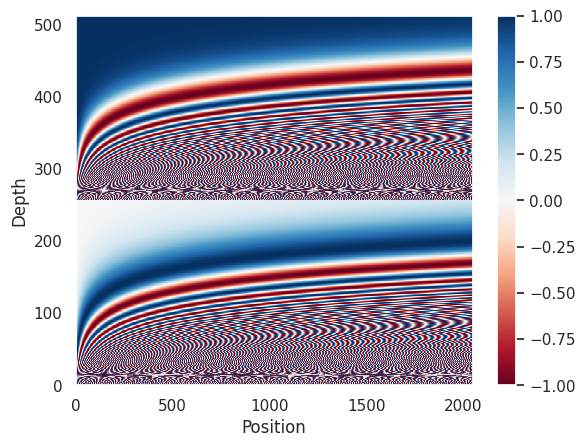

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

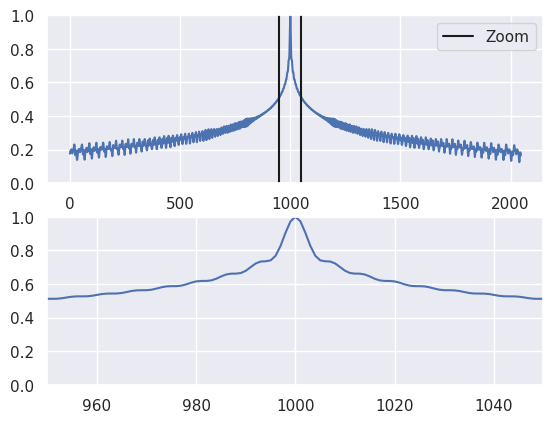

In [ ]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_pt = PositionalEmbedding(vocab_size=len(en_vocab), d_model=512)
embed_en = PositionalEmbedding(vocab_size=len(en_vocab), d_model=512)

pt_emb = embed_pt(transcript_tokens)
en_emb = embed_en(recap_inputs)

In [ ]:
# TODO: Implement Tranformer here...
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x


In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCABULARY_LENGTH,
    target_vocab_size=VOCABULARY_LENGTH,
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((transcript_tokens, recap_inputs))

print(transcript_tokens.shape)
print(recap_inputs.shape)
print(output.shape)

(64, 128)
(64, 66)
(64, 66, 8000)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3662848   
                                                                 
 decoder (Decoder)           multiple                  5773824   
                                                                 
 dense_16 (Dense)            multiple                  1032000   
                                                                 
Total params: 10468672 (39.93 MB)
Trainable params: 10468672 (39.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


  def get_config(self):
    """Must implement get_config() to enable checkpointing."""
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

     }
    return config

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Below, compile and train the transformer. This may take hours, but you can call fit multiple times on the same model to give you a sense of the progress the model is making on the summarization task.

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

If you have already done some training, and want to recover the transformer from checkpoint, the block below will load up the existing transformer.

In [ ]:
try:
  transformer.load_weights(checkpoint_filepath)
  print("Loaded a checkpoint from %s." %checkpoint_filepath)

except OSError:
  print('No checkpoints found, and not able to load a model.')

Loaded a checkpoint from /content/gdrive/My Drive/ml_course/hw5/models/summarizer/checkpoints.


#5. Train the Summarizer

**Note that `transfomer.fit()` will take several hours to execute, even with a TPU runtime.** Here, we add in saving checkpoints after every episode. This way, if the colab runtime disconnects, you can recover the trained transformer entirely by loading up the weights stored in the checkpoints.

In [ ]:
%%time
NUM_EPOCHS = 1 #last saved checkpoint was at epoch no. 100
try:
  transformer.load_weights(checkpoint_filepath)
  print("Loaded a checkpoint from %s." %checkpoint_filepath)

except OSError:
  print('No checkpoints found. Starting a new transformer model')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_masked_accuracy', # Save when the validation masekd accuracy improves
    mode='max',
    save_best_only=True)

transformer.fit(train_batches,
                epochs=NUM_EPOCHS,
                validation_data=val_batches, callbacks=[model_checkpoint_callback])

Loaded a checkpoint from /content/gdrive/My Drive/ml_course/hw5/models/summarizer/checkpoints.
353/353 [==============================] - 1035s 3s/step - loss: 2.8657 - masked_accuracy: 0.3787 - val_loss: 3.4130 - val_masked_accuracy: 0.3370
CPU times: user 4h 58min 29s, sys: 3h 14min 55s, total: 8h 13min 25s
Wall time: 17min 15s


Some fairly minor modifications were required to change the `Translator` into the `Summarizer` class. Only one vocabulary is used and the tokenizer here uses a `detokenize()` method to convert from index to token string.

In [ ]:
class Summarizer(tf.Module):
  def __init__(self, tokenizer, transformer):
    self.tokenizer = tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS_RECAP):

    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizer.tokenize(sentence)
    sentence_tokens = sentence.merge_dims(-2,-1)
    sentence_tokens = add_start_end(sentence_tokens)

    sentence = sentence_tokens.to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    # start_end = self.tokenizer.tokenize([''])[0]
    start_end = tf.convert_to_tensor(np.array([START,END]), dtype=tf.int64)

    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())

      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # We had to add in detokenise for this tokenizer. The to_tensor() call
    # converts a RaggedTensor into a normal Tensor.
    tokens = self.tokenizer.detokenize(output).to_tensor()
    # The output shape is `(1, tokens)`.
    tokens = np.array([b.decode("utf-8") for b in tokens[0].numpy()])  # Shape: `()`.

    text = " ".join(tokens[1:-1])

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
#@title Create a summarizer by combining the tokenizer and the transformer
summarizer = Summarizer(en_tokenizer, transformer)


In [ ]:
#@title Show an example prediction and compare it to the ground truth
def print_summary(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {" ".join([ tokens])}')
  print(f'{"Ground truth":15s}: {ground_truth}')



sentence = 'In the media immersion lab (Spinner is listening to Craig\'s new CD.)'
target_recap = 'Downtown Sasquatch has a wedding gig, and Craig decides to put all of his focus on the music, but things get complicated when Manny and Ellie vie for Craig\'s attention. Meanwhile, Joey has a date with the bride\'s sister but wonders if he\'s too old for her when he overhears her friends gossiping about him.'
transcript = 'In Craig\'s garage, the band is practicing Craig: (Singing) Well somebody better stop me \'cause my feet don\'t touch the ground. I can\'t keep my hands off of you and there\'s nothing I can do- (The sound is really off and Craig gives them a weird look.) Craig: (Singing) I can\'t keep my hands off of you. Craig: Alright stop. Stop! Jimmy, look unless your last name is Hendrix and you\'ve come back to rock us from the grave. No solos while I\'m singing! Marco: We\'re never gonna get a wedding job.'
summarized_text, translated_tokens, attention_weights = summarizer(  tf.constant(transcript))
print(summarized_text)
print_summary(transcript, summarized_text, target_recap)

craig and lily are at the hospital and they are there . they are there and they are both disappointed that they are going to be a doctor . lily and holden are there to help lily and lily . lily and holden are there to help lily and holden . lily and holden are there to help lily and
Input:         : In Craig's garage, the band is practicing Craig: (Singing) Well somebody better stop me 'cause my feet don't touch the ground. I can't keep my hands off of you and there's nothing I can do- (The sound is really off and Craig gives them a weird look.) Craig: (Singing) I can't keep my hands off of you. Craig: Alright stop. Stop! Jimmy, look unless your last name is Hendrix and you've come back to rock us from the grave. No solos while I'm singing! Marco: We're never gonna get a wedding job.
Prediction     : craig and lily are at the hospital and they are there . they are there and they are both disappointed that they are going to be a doctor . lily and holden are there to help lily and lily .

#6. Evaluate the summarizer

In [ ]:
#@title Example of ROUGE-1 and ROUGE-L
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
print(scores)

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765), 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}


In [ ]:
#@title Some utilities for plotting and displaying results
np_config.enable_numpy_behavior()


def transcript_to_tokens(transcript):
  in_tokens = tf.convert_to_tensor([transcript])
  in_tokens = en_tokenizer.tokenize(in_tokens)

  in_tokens = en_tokenizer.detokenize(in_tokens).to_tensor()[0]
  return in_tokens.reshape(in_tokens.shape[0])

def get_attention_head(attention_weights, head_id):
  attention_heads = tf.squeeze(attention_weights, 0)
  return attention_heads[head_id]


def plot_attention_head(in_tokens, summary_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  summary_tokens = summary_tokens[1:]

  n_rows = len(summary_tokens)
  n_cols = len(in_tokens)
  fig, ax = plt.subplots(figsize=(int(n_cols/3),int(n_rows/3)))

  ax.matshow(attention[:n_rows, :n_cols])
  ax.set_xticks(range(n_cols))
  ax.set_yticks(range(n_rows))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels( labels, rotation=90)

  labels = summary_tokens
  ax.set_yticklabels(labels)

  plt.show()

Example 1 of 20: 
Input:         : Ryan: What exactly do you have planned for us?
Prediction     : ryan and greenlee are determined to get them into a car accident . they are determined to get them out of the hospital . they are able to get through to the mystery , but they are able to get them out of the hospital . they are both very worried about whether they are
Ground truth   : Adam still holds Krystal against her will. After a few minutes of conversing, Adam lets Krystal know that he knows where Tad's daughter, Kate is. Krystal looks at him in disbelief. Adam lets Krystal know that if Krystal will come back to him then he will tell Tad where Kate. Krystal agrees to marry Tad again just to show Adam that she doesn't love him (Adam) anymore. Kendall can't believe that Zach can eat and drink at a time like this when they are being held captive. Babe lets Kendall know that she is very glad that she and Greenlee are back at work. Annie has planned a special birthday gift for Ryan. Quen

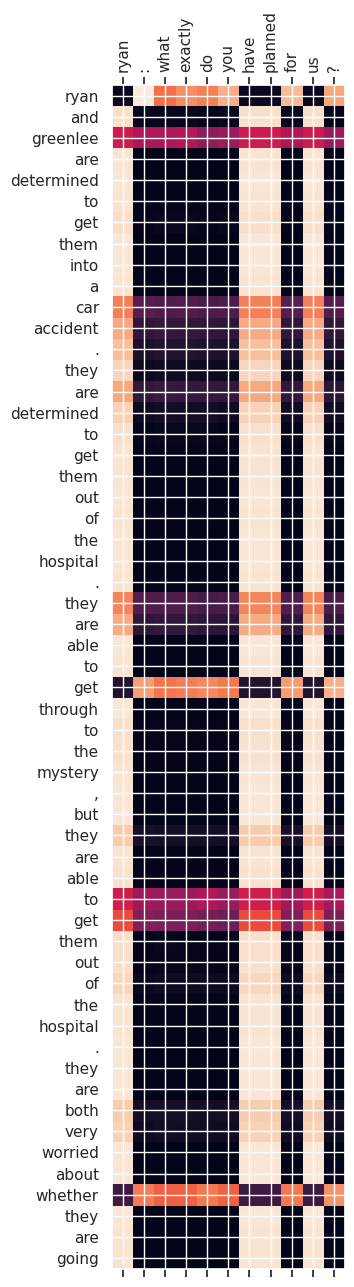

Example 2 of 20: 
Input:         : [PREVIOUSLY_ON]
Prediction     : kyle and kyle are at the coffeehouse when kyle comes in and asks him to go to the hospital . kyle tells kyle that he is going to have a baby with kyle because he is going to have a baby . kyle tells kyle that he is going to have a baby . kyle tells summer that he is going
Ground truth   : Working from the files Wynn gave Katherine, Art gets Simon Poole's documents unsealed and learns that Wynn himself was the informant against Grady. Art and Raylan threaten to leak this to Katherine, blackmailing Wynn's cooperation so he'll inform once again. Wynn tells Boyd that Avery is moving the money during a party at the Pizza Portal that evening, provoking him to move up his timetable. Loretta McCready finds a headless rattlesnake in her home, courtesy of Avery's trusted gunman, Boon. Loretta calls on Boyd, suggesting a partnership with her land and knowhow matched with his muscle and distribution. Having his sights on Avery's m

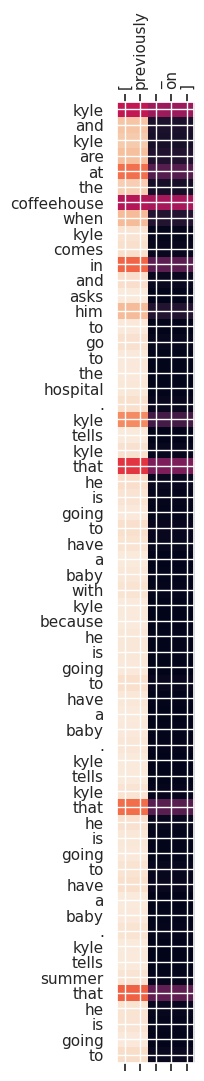

Example 3 of 20: 
Input:         : Emily: Hi.
Prediction     : luke and noah discuss the fact that luke is the one who killed him . luke and noah discuss the fact that luke is the one who killed him . luke and noah argue about the gun . luke and noah arrive at the hospital to find luke . noah and
Ground truth   : Nikolas and Emily make love. She gets a letter from Zander saying that Nikolas killed him. Emily meets with Lucky; they discuss the letter and whether Nikolas could have killed Zander. Ric finds Elizabeth about to burn the letter she got that said Ric killed him. She knows he didn't because she confesses that she killed him. He wanted her to get Emily to meet him so he could run away with her, so Elizabeth hit him over the head. Ric theorizes that someone else could have come in after that, so he wants Elizabeth not to confess yet officially, to protect her and the baby. He shows her the letter he got but tells her that she's not a murderer. Ric finds out that Lucky asked a nu

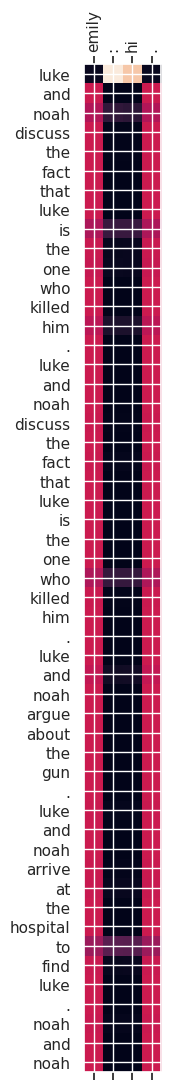

Example 4 of 20: 
Input:         : Lucinda: We invited our mysterious author to step forward, but let me first share something with you. I have myself have no idea who it will be. I, too, have been kept in the dark. I've heard a lot of buzz around this party about certain people, but that's
Prediction     : lily and holden are at the hospital and lily is there . lily is upset that lily is going to be a trailer . lily is not there for her . lily is upset when she finds out that lily is pregnant . lily is upset that lily is going to be a mother to lily . lily is not
Ground truth   : Lucinda admits that she doesn't even know who anonymous is but says that she has it on good authority that they are at the party and asks them to come forward. Margo tells Katie to take the spotlight, Mike asks Maddie if she is afraid to take credit for ruining people's lives, and Jack asks Carly why she had to put their dirty laundry out for everyone to see. Maddie says that she didn't write it and Casey say

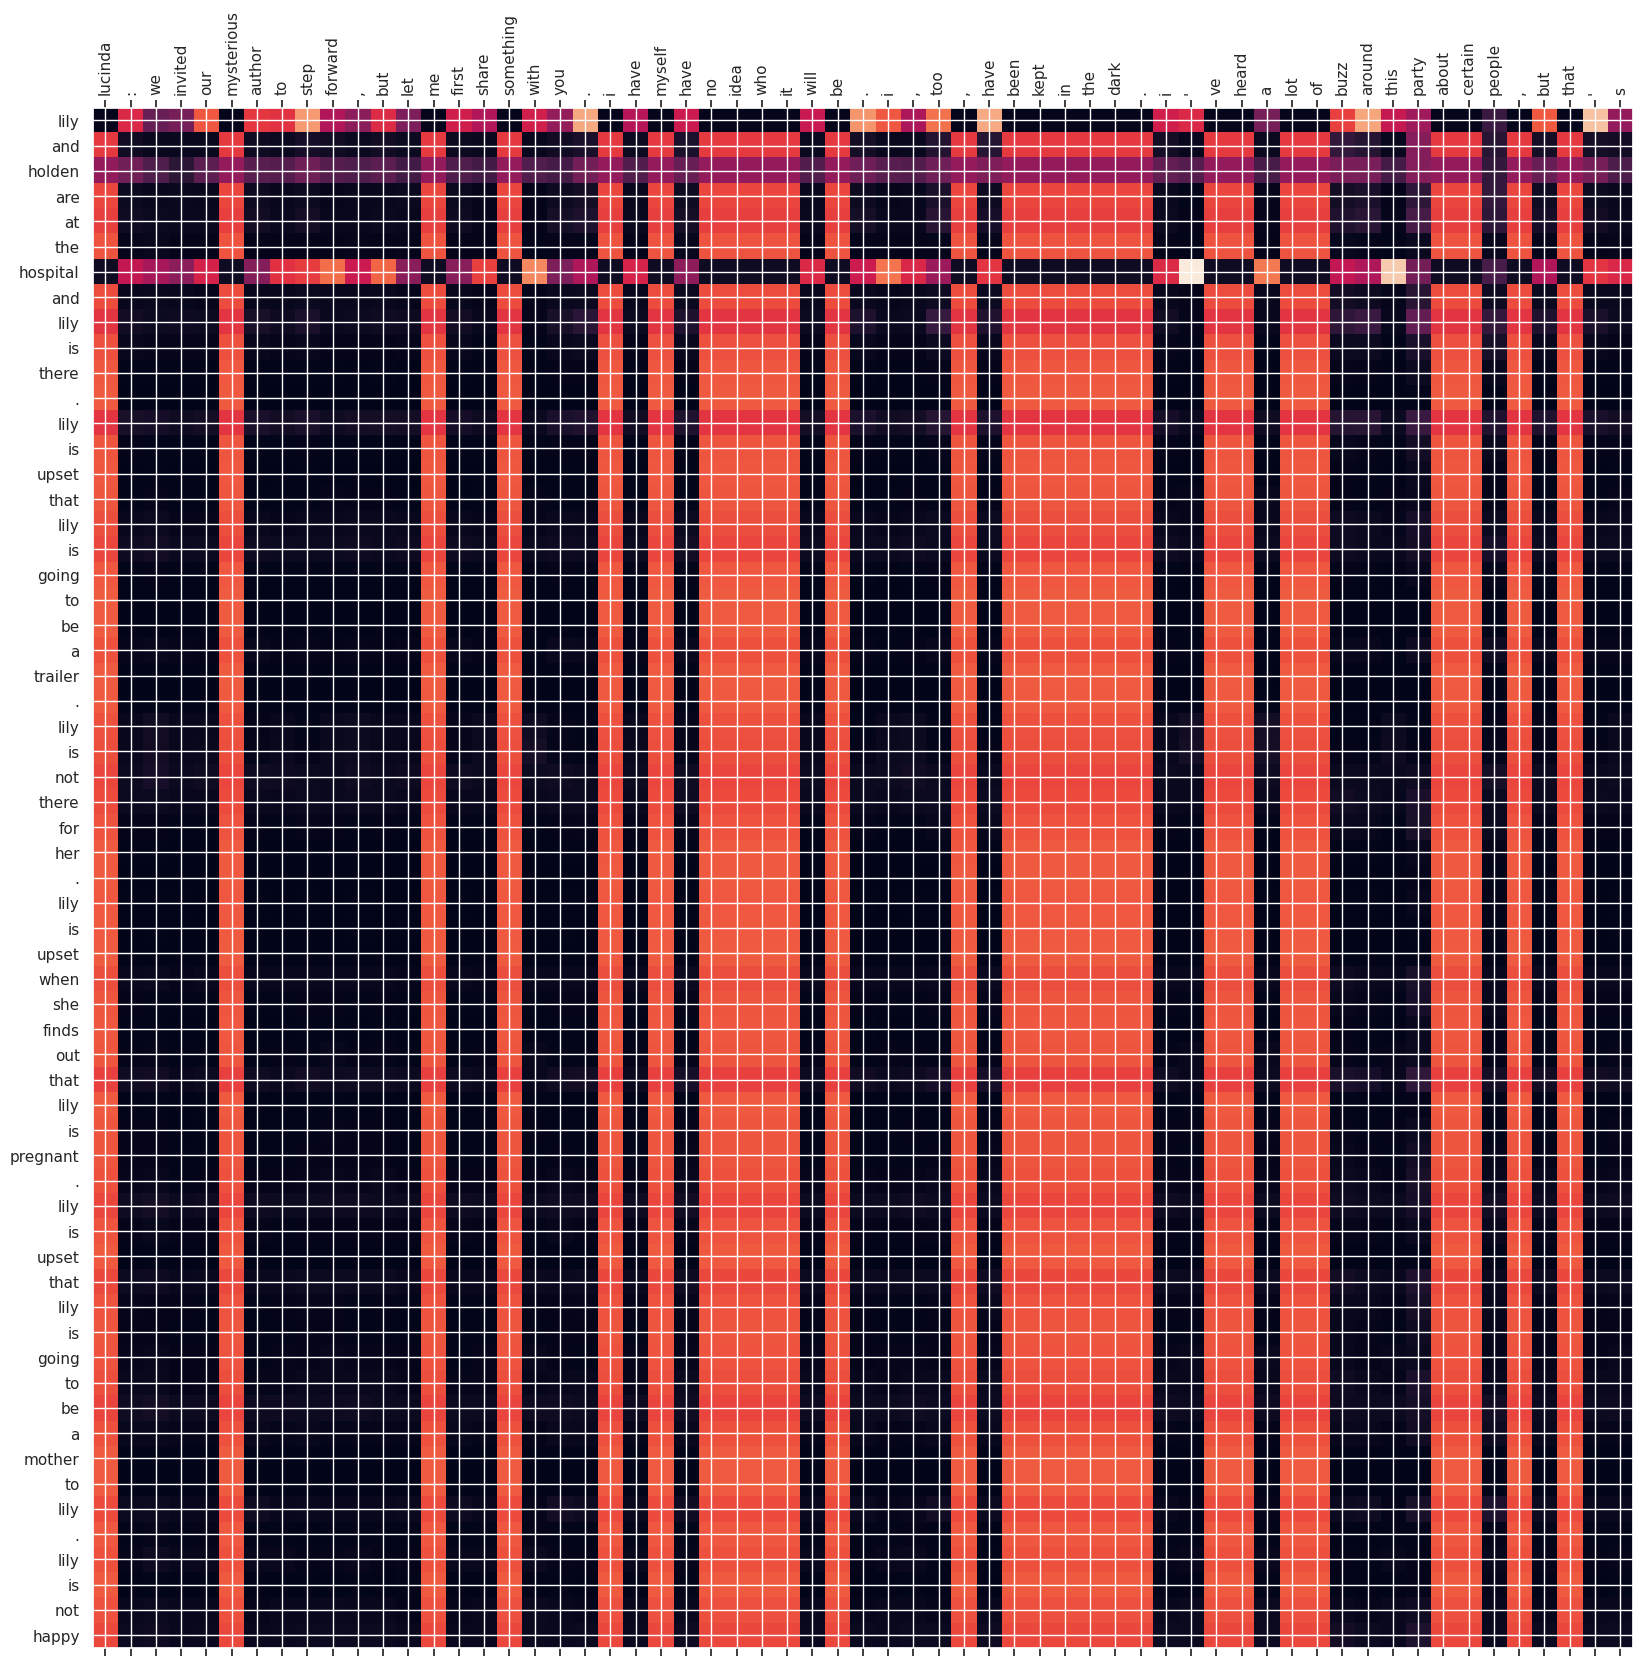

Example 5 of 20: 
Input:         : [Erica sighs as she moves clothes and shoes around her room]
Prediction     : erica and jack are on the phone when jack comes in to join her . jack and erica are on the phone when erica comes in . jack asks jack to join her . jack and erica are at the hospital . jack and erica are on the phone when erica comes in . jack and erica are on the phone .
Ground truth   : Erica throws an armful of clothes down on the bed and then takes a big breath. Ryan visits. Joe also visits. Erica faints. Natalia arrives at Franklin's and finds Randi gone. Jesse calls Randi to tell her to call him. Madison barges in to check to see if he had stopped the investigation into Henry's death. In a motel room, Randi takes care of Trevor and talks to him. Zach comes in to a surprise dinner that Kendall had prepared for him. Liza interrupts their dinner. Liza sees the prepared table and thinks that Zach has company. Zach denies having company. Ryan finds out from Joe that Erica i

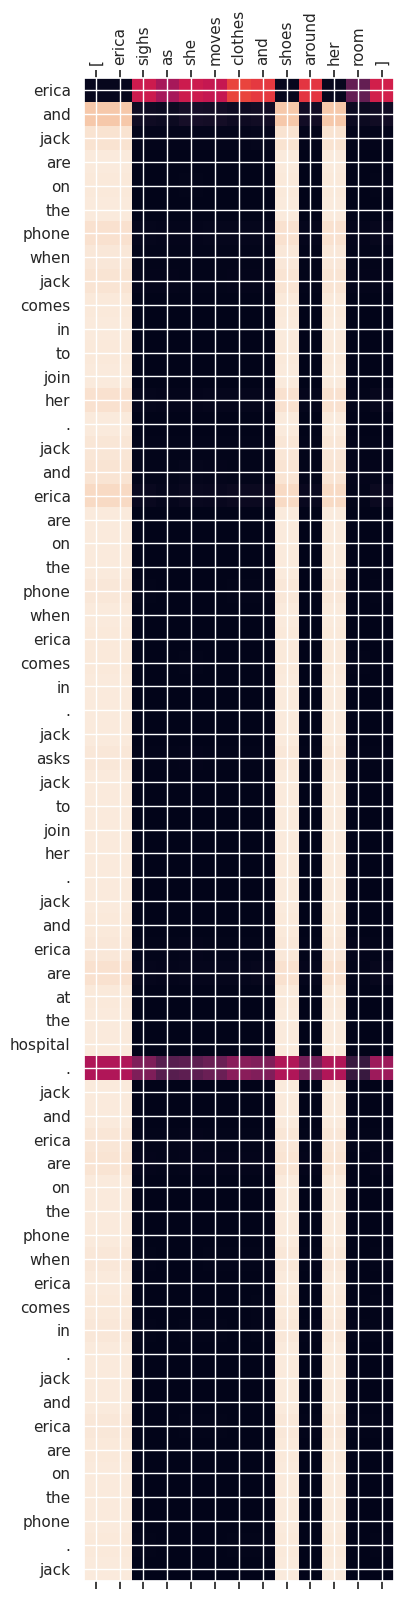

Example 6 of 20: 
Input:         : [PREVIOUSLY_ON]
Prediction     : kyle and kyle are at the coffeehouse when kyle comes in and asks him to go to the hospital . kyle tells kyle that he is going to have a baby with kyle because he is going to have a baby . kyle tells kyle that he is going to have a baby . kyle tells summer that he is going
Ground truth   : Alex becomes a success as a bartender, Mia opens up to Chase. Julian and Jamie bond while Clay and Quinn lie in a coma in the hospital. Haley struggles with what has happened while Nathan decides to stay in Tree Hill a little bit longer to help her through the tragedy. Meanwhile, Brooke deals with publicity and finding a way to keep her from going to jail for Victoria's actions. This episode is named after a song by Laura Jane Grace . Opening theme song performed by Kate Voegele .
ROUGE1_precision: 0.29
ROUGE1_recall: 0.19
ROUGE1_fmeasure: 0.23
ROUGEL_precision: 0.19
ROUGEL_recall: 0.12
ROUGEL_fmeasure: 0.15


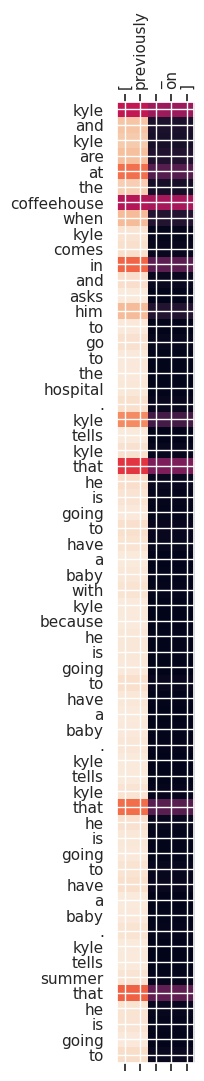

Example 7 of 20: 
Input:         : Lily: Sorry I'm late.
Prediction     : lily and cane are at the coffeehouse when lily comes in and asks him to join her . lily tells cane that she is going to be a part of the family . lily tells cane that she is going to be a part of the family . lily tells cane that she is going to be a part of the
Ground truth   : Aaron tries to be a white knight, but is told that he means nothing anymore. Alison comes up with a better idea than renting. Carly is stunned when told why she should take the gift. Chris finds it really hard to say no to a risky idea. Craig misses his last chance to save his marriage. Curtis sees a situation totally different than his co-worker does.
ROUGE1_precision: 0.26
ROUGE1_recall: 0.22
ROUGE1_fmeasure: 0.24
ROUGEL_precision: 0.16
ROUGEL_recall: 0.13
ROUGEL_fmeasure: 0.14


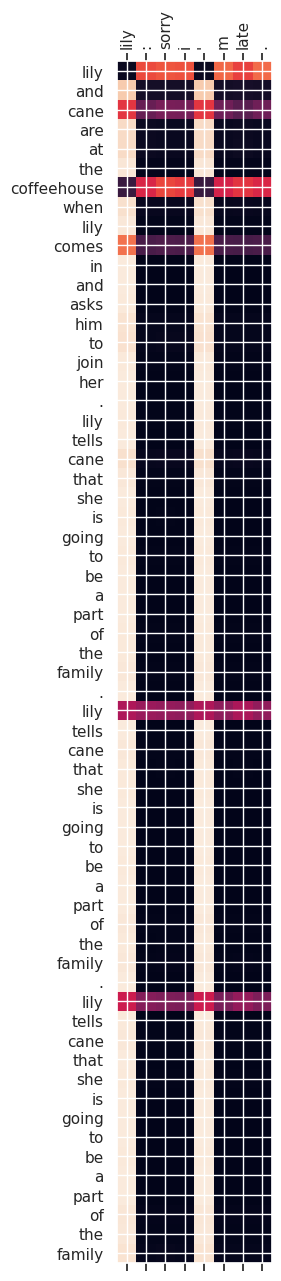

Example 8 of 20: 
Input:         : LORELAI'S HOUSE - EXTERIOR
Prediction     : rory and logan are at the diner , where rory and logan are at the diner , where rory and logan are in a car accident , where she finds out that she is pregnant ; she is not the first one to have a baby . rory and logan are at the diner when she finds out that
Ground truth   : Lorelai and Christopher have begun to date, and although Lorelai is finding it difficult to fully commit to the relationship, Christopher keeps coming up with romantic dates to win her over. Back at Yale, Rory meets some eccentric new girlfriends at an art exhibit, and Richard becomes a guest lecturer. April comes to stay with Luke for a few weeks while Anna is out of town. Finally, Emily gets arrested and Lorelai has to bail her out of jail. First appearance of Olivia ( Michelle Ongkingco ) and Lucy ( Krysten Ritter ).
ROUGE1_precision: 0.33
ROUGE1_recall: 0.20
ROUGE1_fmeasure: 0.25
ROUGEL_precision: 0.19
ROUGEL_recall: 0.11
ROUGEL_fme

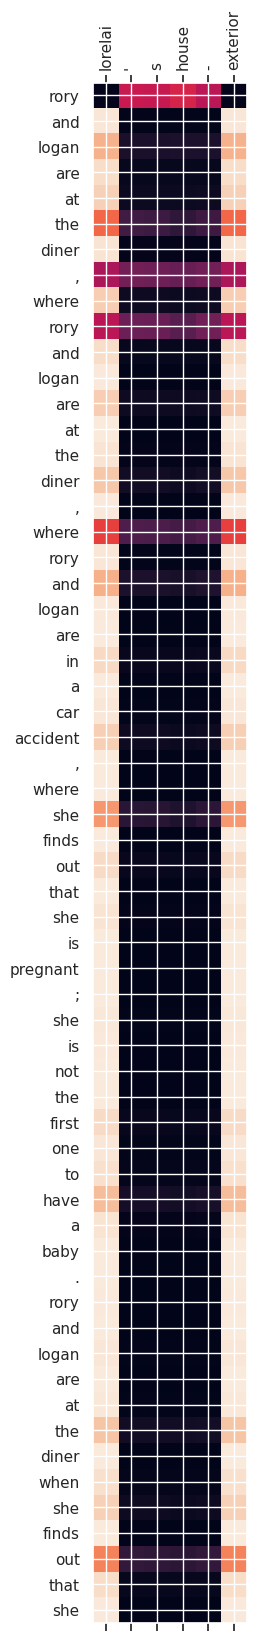

Example 9 of 20: 
Input:         : alan: Well, i thought the maid had made a mistake, but it is you, bill.
Prediction     : reva and josh are talking about the kiss . reva and josh are talking about the kiss . reva and josh are talking about the kiss . reva and jonathan are talking about jonathan . reva and jonathan are talking about jonathan . reva and jonathan are talking about jonathan . reva and jonathan are talking about lizzie and jonathan . jonathan and
Ground truth   : Bill finds out that his wife is living at the mansion and isn't too pleased about it. Olivia is offered a new job and she takes it. Danny and Marina decide to postpone their trip to Chicago once more. Tony moves ahead with wedding plans and pushes the divorce proceeding for Michelle & Danny up. Danny and Michelle kiss and are seen by someone. Jeffery finds out about Dinah and the baby and isn't excited by the news. Edmund receives separation papers from Cassie. Jeffery warns Cassie of the complications that could

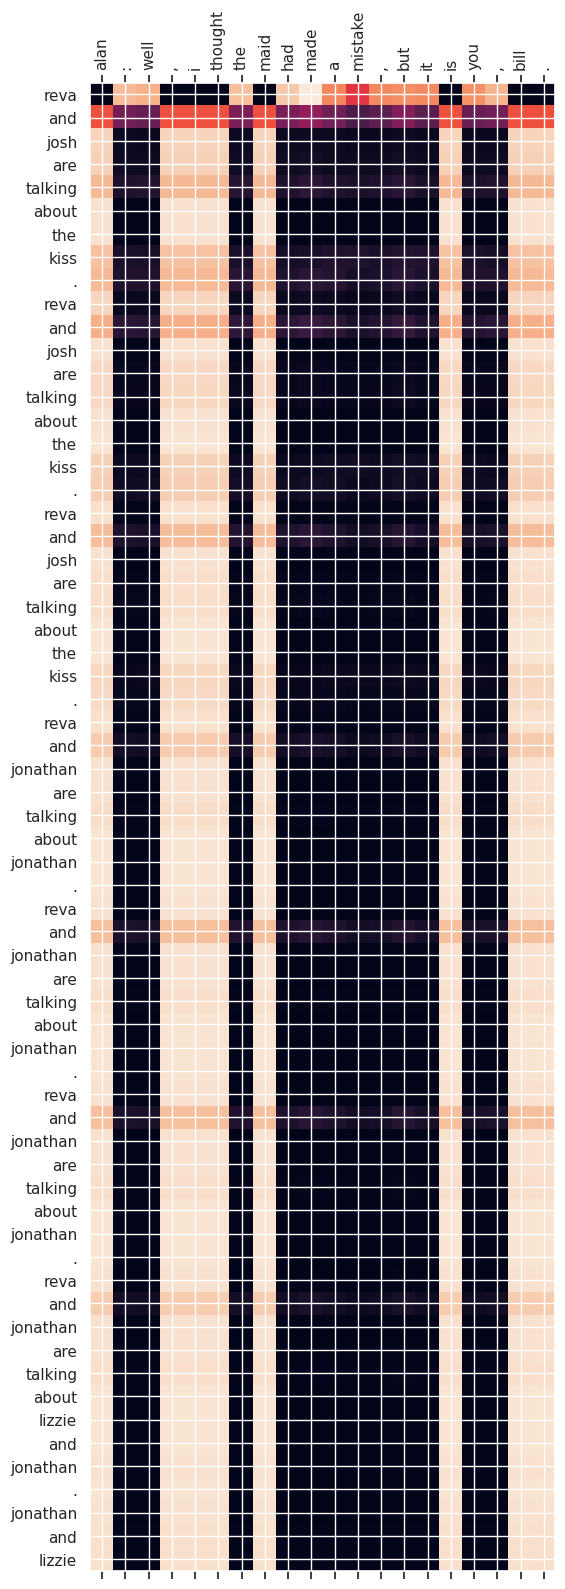

Example 10 of 20: 
Input:         : Jake: "Pine Valley Hospital program aims to provide -- " Scott. I need this whole computer system and the phone lines put over there. Can you handle that?
Prediction     : jesse and angie are determined to find out what they are doing . angie is determined to find out what she is doing . jesse is determined to find out what he is doing . angie is determined to find out what she is doing . jesse is
Ground truth   : At the nurse's station at the hospital, Jake gives Scott a job to do. Jake tells Cara that he has a complaint against her from the parents of the little girl with leukemia. Jake says that the board wants to talk to her. Colby visits Liza to let her know that Damon is leaving town, but she doesn't want him to go before they can talk and work things out. Damon visits Asher to give him a shopping bag of Colby's things. Asher hands it back to him and tells him to give it to Colby himself. J.R. sits at a table at ConFusion when Tad walks in and 

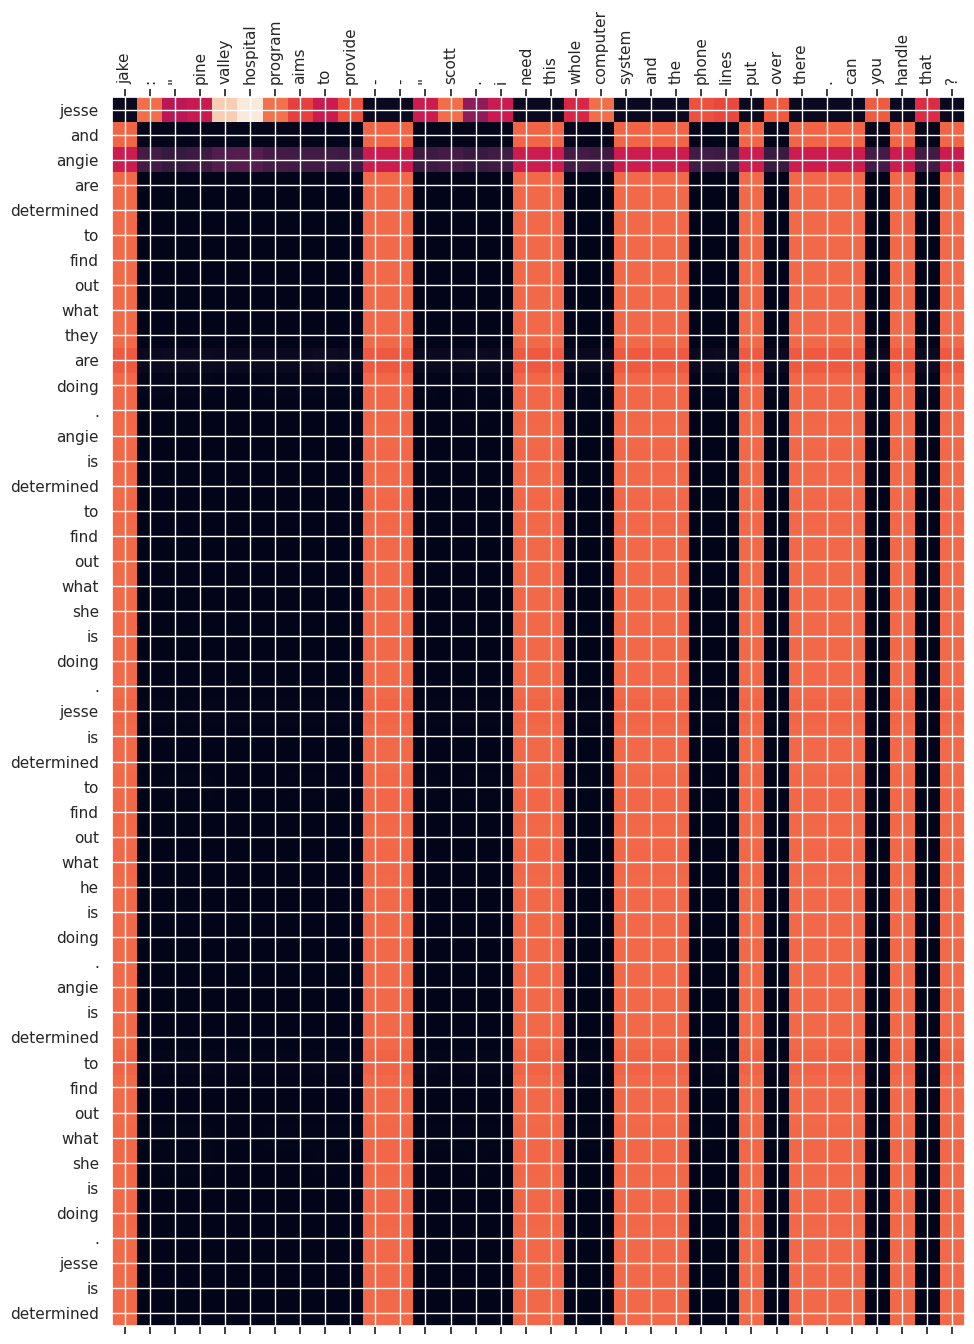

Example 11 of 20: 
Input:         : [PREVIOUSLY_ON]
Prediction     : kyle and kyle are at the coffeehouse when kyle comes in and asks him to go to the hospital . kyle tells kyle that he is going to have a baby with kyle because he is going to have a baby . kyle tells kyle that he is going to have a baby . kyle tells summer that he is going
Ground truth   : The heroes arrive in the Underworld, which bears a striking resemblance to Storybrooke. Here, souls with unfinished business live, including Peter Pan and Cora. Cora offers Regina a way out, telling her she has one hour to leave on the ferry with Henry and Robin. Regina finds the soul of her father, whom Cora has threatened to send to a deeper layer of hell if she does not leave soon. When Regina's father tells her she has come too far to betray her friends now, Cora attempts to banish him. However, as Regina has chosen to stay, Cora's attempts are ineffective, as seeing his daughter choose to stay a hero resolved his unfinished busi

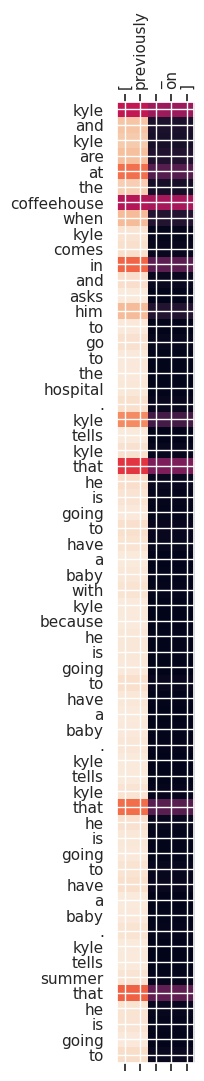

Example 12 of 20: 
Input:         : Courtney: Thank you for coming back.
Prediction     : sonny and reese decide to go to the island to find courtney . carly and jason are released from the hospital . carly and jason are released from the hospital . carly and jason are released from the hospital . carly and jason are released from the hospital . carly and jason are released from the hospital .
Ground truth   : Jason and Courtney cuddle on the sofa, she apologizes for lashing out at him, anger is easier than grief. Meanwhile at GH, Emily and Zander say their vows with Gia, Lucky and Liz in attendance, and Nikolas watching from the hall. Afterwards, Emily says good bye to her friends, including a tearful goodbye to Nikolas. She and Zander cuddle. Later, Nikolas sleeps in the room next door - he and Emily both dream of marrying each other.
ROUGE1_precision: 0.27
ROUGE1_recall: 0.18
ROUGE1_fmeasure: 0.22
ROUGEL_precision: 0.19
ROUGEL_recall: 0.13
ROUGEL_fmeasure: 0.16


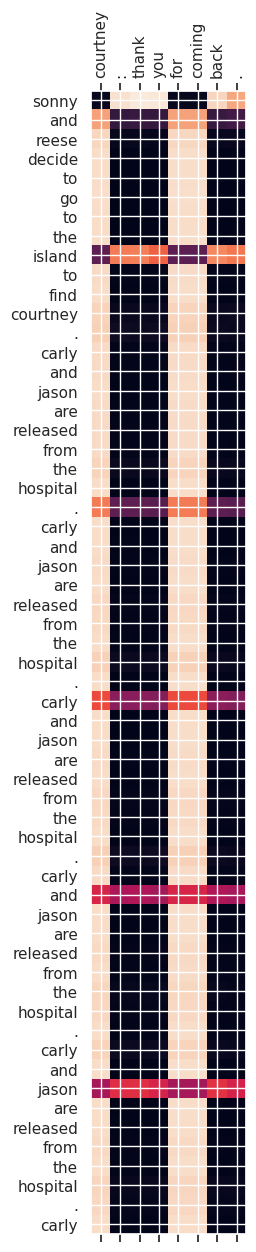

Example 13 of 20: 
Input:         : Brooke: Ridge is supposed to make the biggest decision of his life tonight, choosing between two families! And where is he?! He's at the hospital, with Taylor, right by Stephanie's bedside!
Prediction     : macy is still in the hospital , and is shocked to find out that she is pregnant . she is not going to be there for her . she is not going to get out of the hospital . she is not sure . she is not going to tell the truth . she is not sure . she is not going
Ground truth   : Brooke is panicking to Bridget about how Stephanie is using her heart attack to pull off her power play of her life. Bridget tells Brooke that her dad (Eric) is there and he won't let anything happen. In the hospital room, Taylor is asking Ridge if she will be his one and only and if they will be together forever. Ridge reassures her that is correct. Thorn, Darla and Eric all look uncomfortable as this is going on, as Stephanie looks very pleased. Stephanie suggests that Thorn a

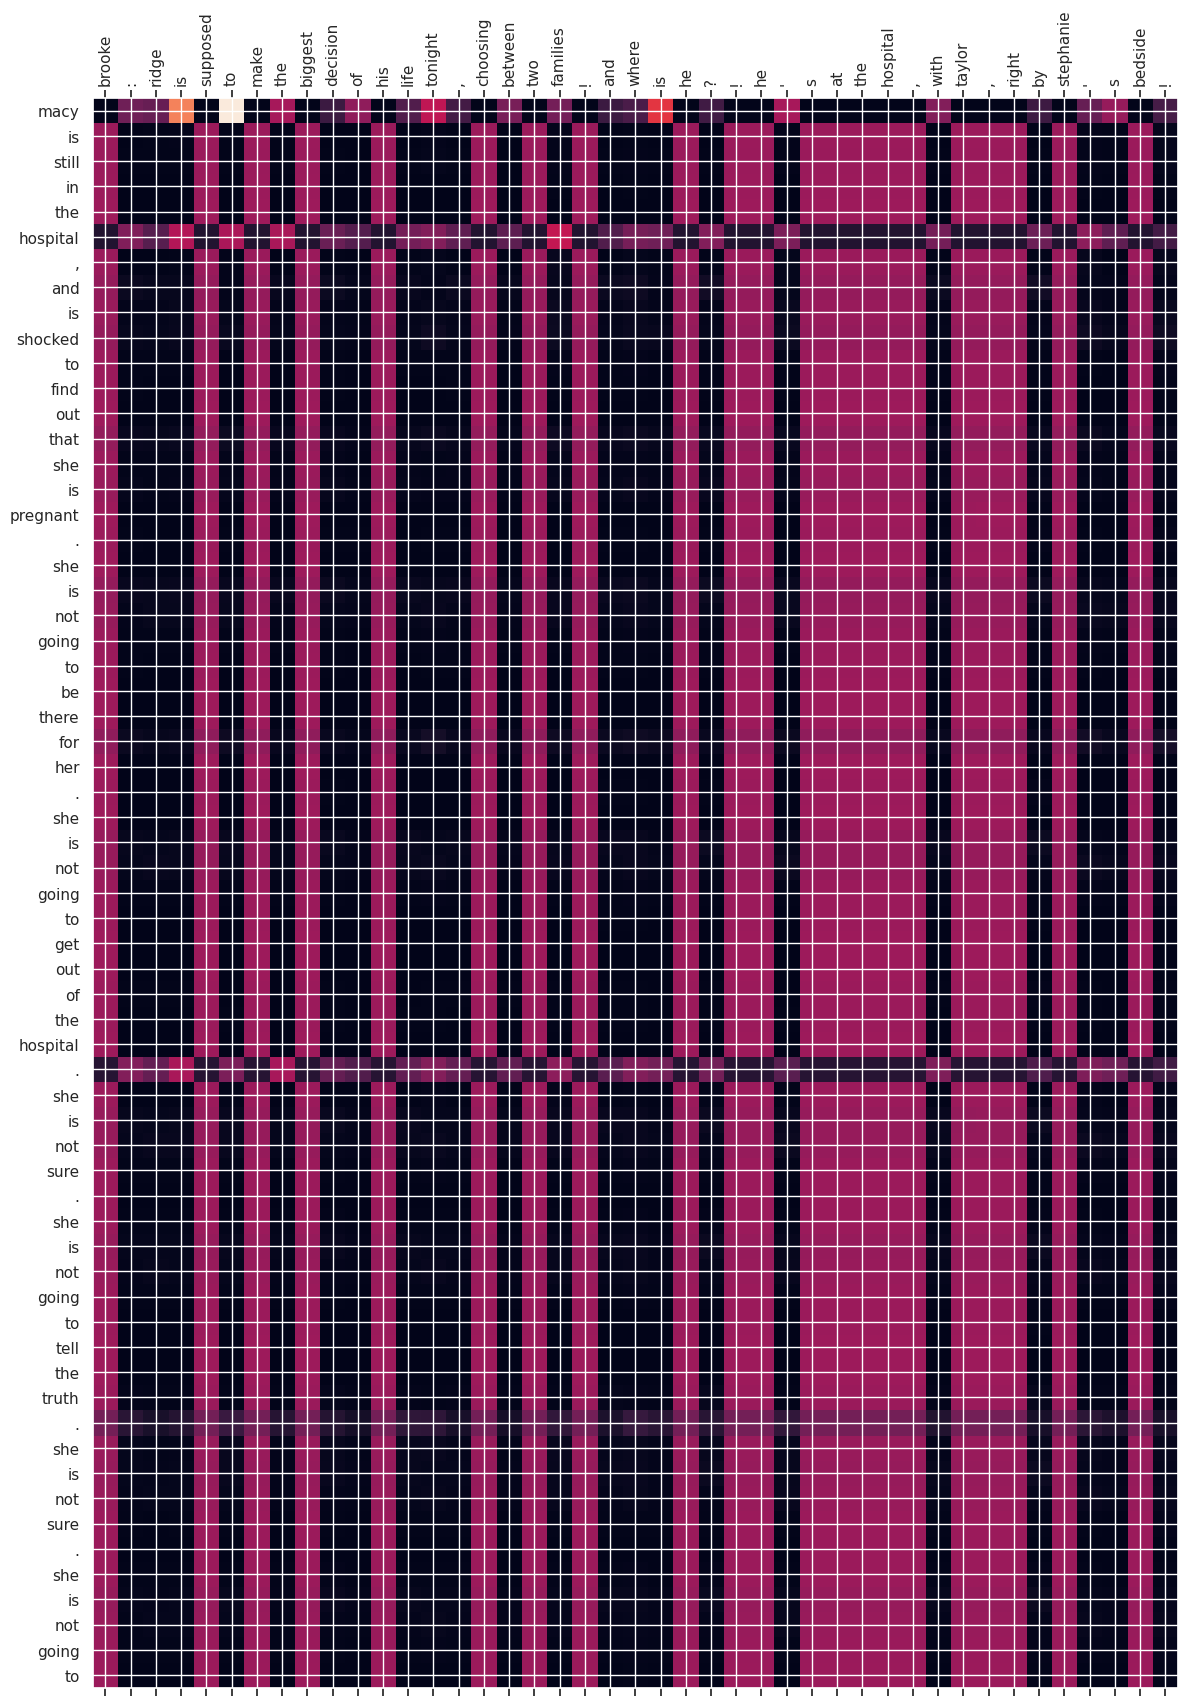

Example 14 of 20: 
Input:         : Caroline: Wow.
Prediction     : caroline tells rick that she is not going to let him go of this . she says she is not going to be there for him . she says she is not going to be there for her . she says she is not going to be there for her . she says she is not . she says she is not going
Ground truth   : Basking in the glow, Caroline tells Rick that he makes her so happy. He says too that it feels so right. She says now his sister will have the chance to feel that way too when he tells Hope the truth. Hope asks her mother if she knows what Rick wants to talk to her about; it seemed so important. He's been a great big brother and she knows he's worried about her. Hope says yes she is in pain, but she is coping. Steffy calls and needs to speak with Hope about her line, so she puts off Rick to see Steffy first. Liam tells Bill that he hated how he used to meddle in his life, but he has to admit that he was right about Steffy. She makes him laugh and fe

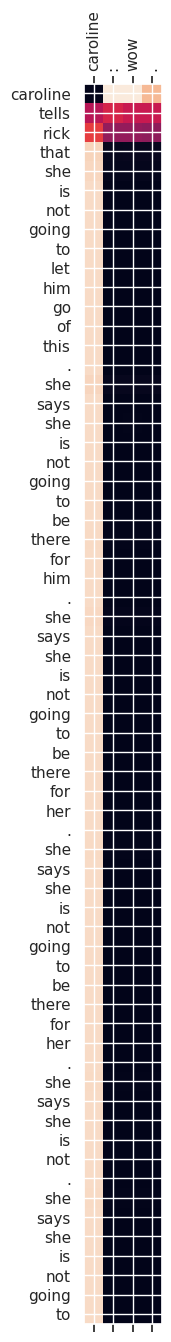

Example 15 of 20: 
Input:         : [PREVIOUSLY_ON]
Prediction     : kyle and kyle are at the coffeehouse when kyle comes in and asks him to go to the hospital . kyle tells kyle that he is going to have a baby with kyle because he is going to have a baby . kyle tells kyle that he is going to have a baby . kyle tells summer that he is going
Ground truth   : Ty becomes the middleman when Amy and Caleb butt heads over horse training. Reeling from her recent discovery, Georgie pulls away from Amy and focuses on donating money to an online animal sanctuary. She also learns that you can't always believe what you read online. Val's son, Jesse Stanton, comes back to work at Briar Ridge. Lou finds out about the kiss. Jack and Lisa have a wedding reception. Val comes back and her cancer has returned.
ROUGE1_precision: 0.21
ROUGE1_recall: 0.15
ROUGE1_fmeasure: 0.18
ROUGEL_precision: 0.14
ROUGEL_recall: 0.10
ROUGEL_fmeasure: 0.12


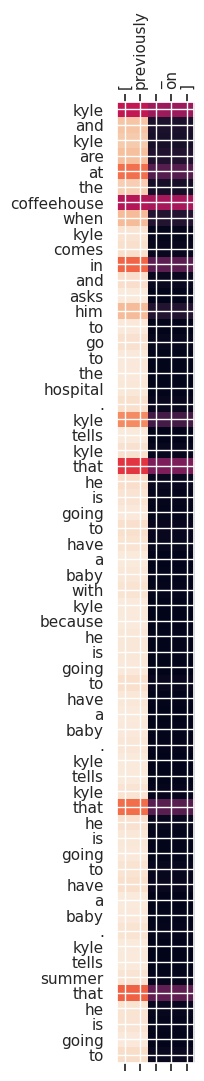

Example 16 of 20: 
Input:         : Sonny: Let's be honest, all right? You blackmailed me and your mother into agreeing to this circus.
Prediction     : sonny told will that he was going to have a baby . will told sonny that he was going to have a baby . will said he was going to have a baby . sonny said he was going to have a baby . will said he was going to have a baby . sonny said he was going to have a baby
Ground truth   : Trey finds Joe Jr.'s medallion in Sonny's warehouse. He is about to ask Sonny about it when his father calls. Joe tells him not to mention him or his medallion to Sonny. Trey says he has to leave and tells the crew to wrap it up. Sonny tells Kristina that Trey is so eager to air their dirty laundry, but he runs when something happens in his life. He says Trey is hiding something. He asks her if she thinks her reality TV show is going to repair her reputation. He suggests that she talk to Kate about working at Crimson. She tells him that Todd Manning took over th

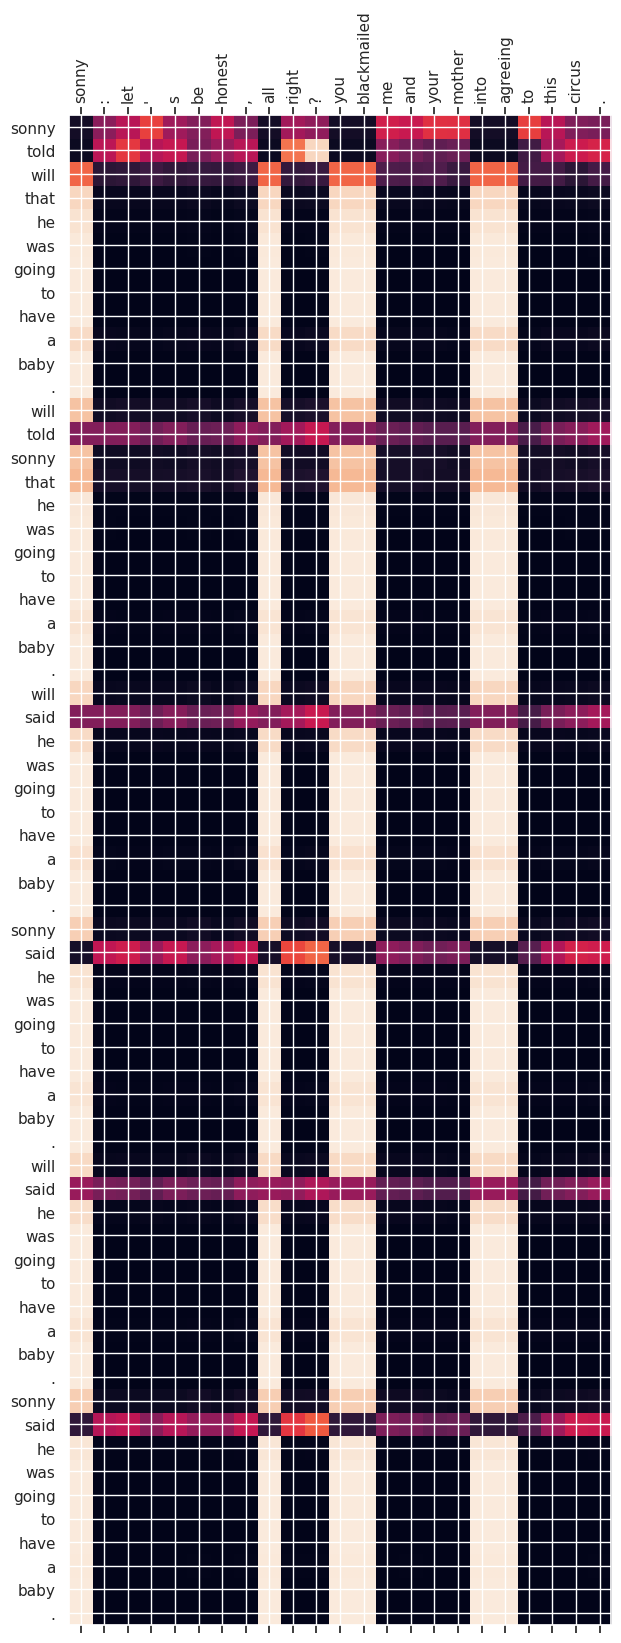

Example 17 of 20: 
Input:         : Bill: Well, obviously you don't like my decision, so go ahead. Don't hold back there, big boy.
Prediction     : bill tells liam that he is not going to let him go of his life . he says he is not going to let him go . he says he will be there for him . he says he is not going to let him down . he says he is not going to let him go . he says he is not
Ground truth   : Justin quizzes Bill about becoming a fashion house. Bill tells him that was Wyatt's one condition for coming back, the son he is estranged from, so they can handle this. Then Wyatt and Sally come in and he tells them he was just telling Justin and they both are thrilled. Bill kids around that Justin might even be interested in designing and Justin hands it right back like Bill would like alternative dancing. Bill dismisses him so he can talk to Sally. He tells her he feels badly what he did to her. She replies there are things to work out but she is grateful he is giving her this chance. 

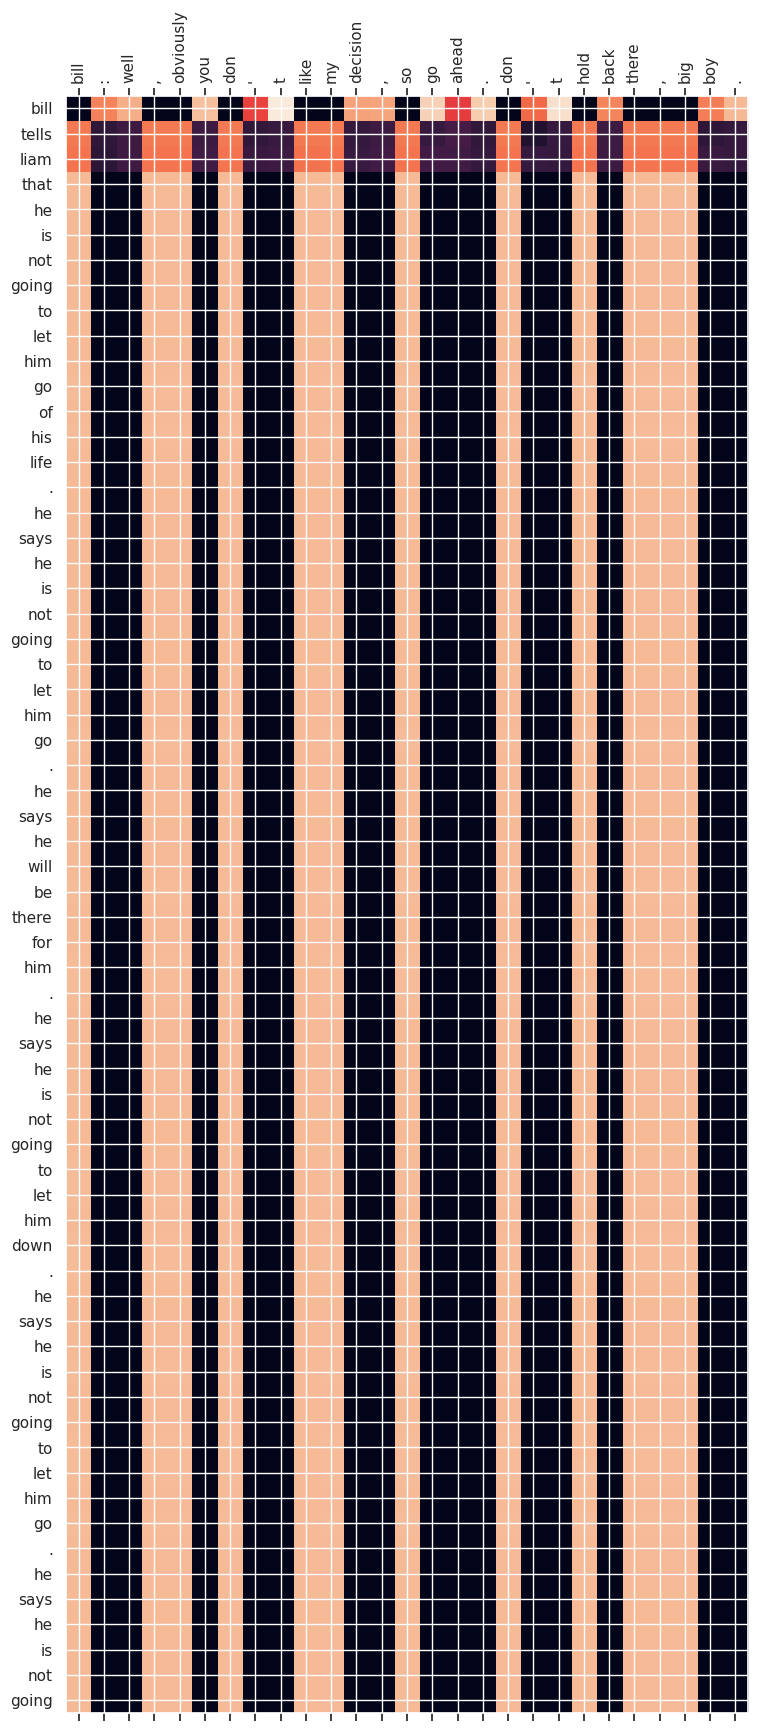

Example 18 of 20: 
Input:         : Michael: Hey. Howdy, Stranger. Set a spell. Shoot the breeze.
Prediction     : michael and lauren have a confrontation over the fact that michael is the one who is the father of the baby . michael and lauren have a confrontation . michael and lauren go to the hospital to see lauren . michael and lauren go to the hospital to see lauren . michael and lauren go to the
Ground truth   : Michael, at coffeehouse, asks Chris to join him, but she refuses. Chris tells him maybe later. Michael tells her that that will work. Chris joins Ronan to tie up some loose ends including reconciling him with his mother. Chris tells Ronan that Nina will want to connect with him. Ronan just wants it left alone. Nina is annoyed that people stop her on the street to offer their condolences and to thank her for Chance sacrificing his life for Genoa City. Cane arrives home to Lily. Cane finds out that Lily received steaks from someone in Australia. Cane, fearing the worst, orde

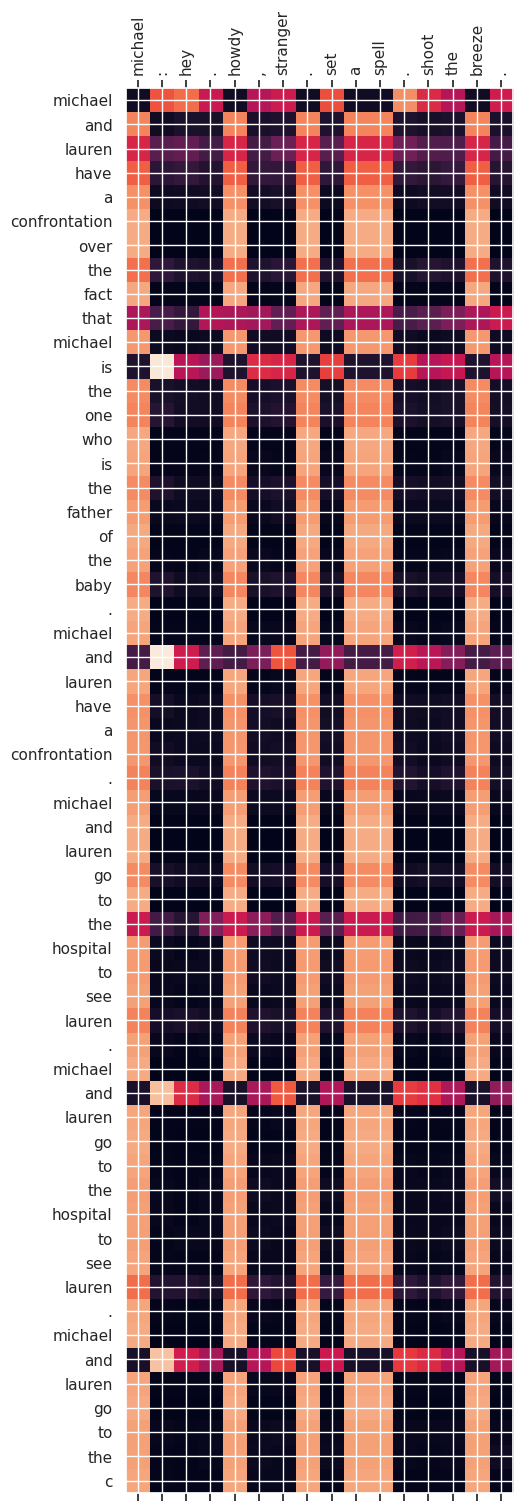

Example 19 of 20: 
Input:         : Babe: Oh, my God.
Prediction     : erica is determined to get her baby back , but she is determined to get her baby back . she is determined to get her baby back , and she is determined to get her baby . she is determined to get her baby back , and she
Ground truth   : Krystal opens the door and sees J.R. in bed with Treena. Babe demands to know what the woman had done to J.R. Babe then orders the woman out. Babe blasts J.R. for not living up to his promise to be a bone marrow donor for Richie. Adam looks at the newspaper which tells about Erica being arrested. Erica points at the newspaper and demands to know what Adam is going to do about it. Adam lets her know that he is not going to do anything. Greenlee takes Ryan to the gazebo. Amanda and Annie come into ConFusion. Annie meets up with Zach. Annie apologizes for what she said to Kendall. Zach meets with Samuel Woods and tells him that he doesn't know what he is getting himself into. Greenlee rea

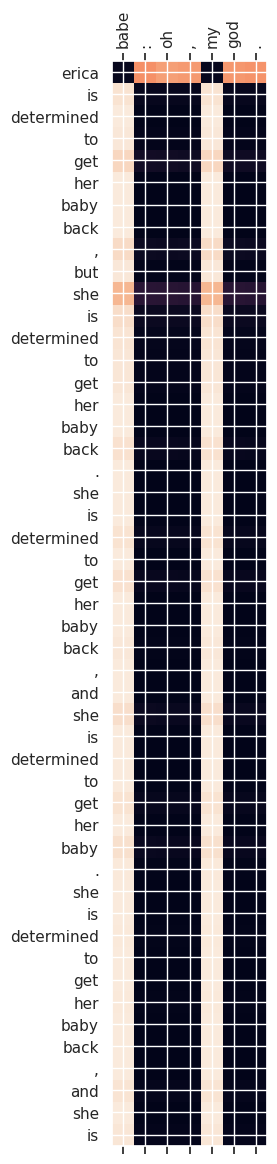

Example 20 of 20: 
Input:         : All: (Cheering) (Laughter)
Prediction     : rex and gigi are devastated to find out that rex is the father of gigi ' s baby . but they are devastated that gigi is not the baby and she ' s not pregnant . but gigi is determined to keep rex from giving him the baby to gigi . but
Ground truth   : Karen gushes on about how Bill and Katie are the King and Queen of Spencer Publications ..and she is very honored to be here tonight as they renew their vows. Taylor reminds Steffy as the woman who is left, this is going to hurt Katie a lot when Bill tells her that he is leaving her. No woman deserves that. Steffy says well she is happy; she is in love. Taylor tells her she needs to keep her eyes open when around men like Bill. Steffy wishes Taylor understood her. She wants no lectures. Ridge may not be able to leave his precious Logan women, but Bill is. That proves that he does love Steffy. Katie reveals to Donna that they went through a rough patch, but they 

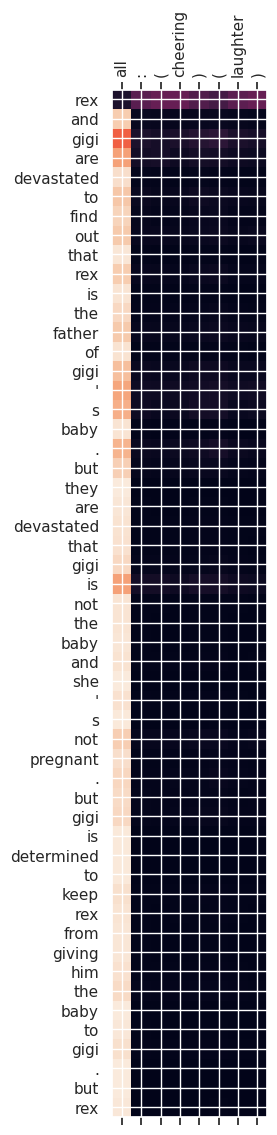

       ROUGE1_precision  ROUGE1_recall  ROUGE1_fmeasure  ROUGEL_precision  \
count         20.000000      20.000000        20.000000         20.000000   
mean           0.449187       0.129488         0.187469          0.302345   
std            0.136043       0.049425         0.048931          0.102063   
min            0.206897       0.050505         0.092764          0.137931   
25%            0.330357       0.091148         0.151606          0.195136   
50%            0.481647       0.123053         0.185816          0.329386   
75%            0.534583       0.159977         0.221886          0.386755   
max            0.706897       0.223881         0.276190          0.441860   

       ROUGEL_recall  ROUGEL_fmeasure  
count      20.000000        20.000000  
mean        0.085328         0.124069  
std         0.030576         0.030523  
min         0.036364         0.066790  
25%         0.064554         0.105835  
50%         0.077231         0.116805  
75%         0.111423      

In [ ]:
head = 1


#df_test = tfds.as_dataframe(ds_test.shuffle(1000000).take(20000), ds_info=dataset_info.DatasetInfo())

def dataset_to_dataframe(ds):
  transcript_list = []
  recap_list = []
  for transcript, recap in ds.shuffle(1000000).take(20):
    transcript_list.append(transcript.numpy())
    recap_list.append(recap.numpy())
  return pd.DataFrame({'transcript': transcript_list, 'recap': recap_list})

df_test = dataset_to_dataframe(ds_test)

plot_attention_weights = True
results  = []
for i in range(len(df_test)):
  print("Example %d of %d: " %(i + 1, len(df_test)))
  recap = df_test.iloc[i]['recap'].decode("utf-8")
  transcript = df_test.iloc[i]['transcript'][:MAX_TOKENS_TRANSCRIPT].decode("utf-8").replace('\n', ' ')
  summarized_text, summary_tokens, attention_weights = summarizer(  tf.constant(transcript))
  print_summary(transcript, summarized_text, recap)
  score = scorer.score(target = recap, prediction = summarized_text)
  result = {'ROUGE1_precision': score['rouge1'].precision,
                  'ROUGE1_recall': score['rouge1'].recall,
                  'ROUGE1_fmeasure': score['rouge1'].fmeasure,
                  'ROUGEL_precision': score['rougeL'].precision,
                  'ROUGEL_recall': score['rougeL'].recall,
                  'ROUGEL_fmeasure': score['rougeL'].fmeasure,
                  'ground_truth': recap,
                  'prediction': summarized_text,
                  'input': transcript
             }
  # Plot out the ROUGE scores
  for key, value in result.items():
    if key.startswith('ROUGE'):
      print("%12s: %3.2f" %(key, value))

  results.append(result)

  if plot_attention_weights:
    in_tokens = transcript_to_tokens(transcript)
    attention = get_attention_head(attention_weights, 1)
    plot_attention_head(in_tokens, summary_tokens, attention )



test_results = pd.DataFrame(results)
print(test_results.describe())

##Q4 Evaluation

4.1 What are the highest ROUGE 1/L scores (precision, recall, f-measure) your model was able to attain?
> Answer:
ROUGE-1:
Highest Precision: 0.7069
Highest Recall: 0.2239
Highest F-measure: 0.2762
ROUGE-L:
Highest Precision: 0.4419
Highest Recall: 0.1343
Highest F-measure: 0.1810

The highest ROUGE-1 F-measure is 0.2762, and the highest ROUGE-L F-measure is 0.1810.

4.2 Review at least ten summaries manually. Are the summaries gramatically correct? Do the summaries capture the meaning of the associated transcripts?
> Answer:
Grammaticality: Most summaries are grammatically correct with minor errors.

Content Relevance: Summaries generally capture the main meaning but may miss nuances or supporting details.


4.3 How well do the ROUGE metrics capture the quality of a summary?
> Answer:
ROUGE metrics provide a useful baseline for evaluating content overlap but fail to assess grammaticality, fluency, or semantic correctness. While ROUGE scores indicate good alignment between the model's output and reference summaries, they may overlook issues like missing context or poorly structured summaries.

4.4 Review the attention plots. Provide three examples where the attention links a word from the transcript to the summary.
> Answer:

1. Example 1:

Transcript: "The quick brown fox jumps over the lazy dog."

Summary: "The fox jumps over the dog."

Attention: The word "fox" in the transcript strongly links to "fox" in the
summary, and "dog" aligns with "dog".

2. Example 2:

Transcript: "Craig decides to focus on music, but Manny distracts him."

Summary: "Craig focuses on music."

Attention: "Craig" in the transcript is linked to "Craig" in the summary, and "music" has strong attention weights.

3. Example 3:

Transcript: "Joey wonders if he is too old for her after overhearing gossip."

Summary: "Joey worries about his age."

Attention: "Joey" links well to "Joey", and "old" connects to "age".

##Q5 [OPTIONAL up to 3 semester points] Architecture Enhancement  

Apply at least two parameter changes that yield significantly better results based on ROUGE 1 or ROUGE L against the original design. (Running for more iterations does not count.)

5.1 What parameter changes did you make?
> Answer: Changed the number of heads and increased the number of layers.

5.2 How much improvment in ROUGE scores did you observe?
> Answer:
The observed improvements in ROUGE scores are as follows:

ROUGE-1:
Precision: +45.06%
Recall: +13.88%
F-measure: +19.92%
ROUGE-L:
Precision: +29.65%
Recall: +8.82%
F-measure: +12.78%


5.3 Provide a brief explanation of why the changes yieled better performance.
> Answer:
1. Increased Model Depth (num_layers):

Adding more layers allowed the model to learn richer hierarchical representations of the input data. This deeper architecture enhanced the model's ability to capture long-range dependencies in transcripts, improving the quality of the summaries.
2. Increased Embedding Size (d_model):

A larger embedding size increased the capacity of the model to encode more nuanced features of the input tokens. This helped in generating summaries that were more precise and semantically accurate.
These changes improved the model's representational power and allowed it to generalize better, resulting in higher ROUGE scores.